# Import

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets, models
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

import numpy as np
import matplotlib.pyplot as plt

import IPython.display as display
from PIL import Image
import pathlib
import os

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.4.0
Keras version 2.4.0
Found GPU at: /device:GPU:0


# Utility functions

In [ ]:
IMG_WIDTH, IMG_HEIGHT = 224,224
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    # print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax

In [ ]:
models_dir = "/content/drive/MyDrive/Colab Notebooks/models/"

def savemodel(model, model_name):
    filename = os.path.join(models_dir, '%s.h5' %model_name)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)


def loadmodel(model_name):
    filename = os.path.join(models_dir, '%s.h5' %model_name)
    try:
        model = load_model(filename)
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:    
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    return model

In [ ]:
def plot_accuracy_graph(mdl, ylower_limit=0.1, yupper_limit=1):
  plt.plot(mdl.history.history['accuracy'], label='accuracy')
  plt.plot(mdl.history.history['val_accuracy'], label = 'val_accuracy')
  plt.title('model accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([ylower_limit, yupper_limit])
  plt.legend(loc='lower right')

def plot_loss_graph(mdl, ylower_limit=0.5, yupper_limit=2):
  plt.plot(mdl.history.history['loss'], label='loss')
  plt.plot(mdl.history.history['val_loss'], label = 'val_loss')
  plt.title('model loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.ylim([ylower_limit, yupper_limit])
  plt.legend(loc='lower right')

# Custom CNN class

In [ ]:
class CustomCNN:

    def _name(self):
        return "CustomCNN"

    def _cnn_block(self, model):
      model.add(layers.Conv2D(filters=self.filters, kernel_size=(3,3)))
      model.add(layers.BatchNormalization())
      model.add(layers.Dropout(0.2)) # 0.2 dropout rate 
      model.add(layers.MaxPool2D())

    def create_model(self):
        model = models.Sequential()

        # Part A
        # first layer
        model.add(layers.Conv2D(filters=self.filters, input_shape = self.input_shape, kernel_size=(3,3)))
        model.add(layers.ReLU())
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.2)) # 0.2 dropout rate 
        model.add(layers.MaxPool2D()) # Default: tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None,**kwargs)
        
        if self.num_layers > 1:
          for i in range(self.num_layers-1):
            print(i)
            self._cnn_block(model)

        # Part B
        model.add(layers.Flatten())
        model.add(layers.Dense(32))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(self.class_number))
        model.add(layers.Softmax())

        return model

    def __init__(self, input_shape, filters, class_number, num_layers):
        super().__init__()
        
        self.input_shape = input_shape
        self.filters = filters
        self.class_number = class_number
        self.num_layers = num_layers
        self.name = self._name()

# Load data

## Classic Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_plain_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/plain/"
train_plain_dir = pathlib.Path(train_plain_dir)
print("Path:", train_plain_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/plain


In [ ]:
image_count = len(list(train_plain_dir.glob('*/*.png')))
print("Total number of images:", image_count)

image_dict = np.array([{item.name: len(list(item.glob('*.png')))} for item in train_plain_dir.glob('*') if item.name != "LICENSE.txt"])
print(image_dict)

Total number of images: 170
[{'Density4Benign': 10} {'Density1Benign': 19} {'Density3Malignant': 13}
 {'Density3Benign': 21} {'Density4Malignant': 2} {'Density2Benign': 6}
 {'Density1Malignant': 48} {'Density2Malignant': 51}]


In [ ]:
CLASS_NAMES = np.array([item.name for item in train_plain_dir.glob('*') if item.name != "LICENSE.txt"])
print("Class names:",CLASS_NAMES)

Class names: ['Density4Benign' 'Density1Benign' 'Density3Malignant' 'Density3Benign'
 'Density4Malignant' 'Density2Benign' 'Density1Malignant'
 'Density2Malignant']


In [ ]:
# # show examples
# density1benign = list(train_plain_dir.glob('Density1Benign/*'))

# for image_path in density1benign[:3]:
#     display.display(Image.open(str(image_path)))

## Load Crop Dataset

In [ ]:
data_crop_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop/"
data_crop_dir = pathlib.Path(data_crop_dir)
print("Path:", data_crop_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop


## Load horizontal flip Dataset

In [ ]:
data_hflip_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/horizontal_flip/"
data_hflip_dir = pathlib.Path(data_hflip_dir)
print("Path:", data_hflip_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/horizontal_flip


## Load vertical flip Dataset

In [ ]:
data_vflip_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/vertical_flip/"
data_vflip_dir = pathlib.Path(data_vflip_dir)
print("Path:", data_vflip_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/vertical_flip


## Load brightness Dataset

In [ ]:
data_brightness_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/brightness/"
data_brightness_dir = pathlib.Path(data_brightness_dir)
print("Path:", data_brightness_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/brightness


## Load cropped and vertical flipped Dataset

In [ ]:
data_crop_vflip_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop_vflip/"
data_crop_vflip_dir = pathlib.Path(data_crop_vflip_dir)
print("Path:", data_crop_vflip_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop_vflip


## Load cropped, vertical and horizontal flipped Dataset

In [ ]:
data_crop_vhflip_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop_vflip_hflip/"
data_crop_vhflip_dir = pathlib.Path(data_crop_vhflip_dir)
print("Path:", data_crop_vhflip_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop_vflip_hflip


## Load cropped, vertical and horizontal flipped and brightness Dataset

In [ ]:
crop_vflip_hflip_brightness_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop_vflip_hflip_brightness/"
crop_vflip_hflip_brightness_dir = pathlib.Path(crop_vflip_hflip_brightness_dir)
print("Path:", crop_vflip_hflip_brightness_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop_vflip_hflip_brightness


# Split data in train and test

## Classic Dataset

In [ ]:
# Divide in train and validation
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = image_generator.flow_from_directory(
        directory=str(train_plain_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

Found 170 images belonging to 8 classes.


In [ ]:
val_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Test/"
val_data_gen = image_generator.flow_from_directory(
        directory=val_dir,
        batch_size=32,
        shuffle=False,
        target_size=(224, 224),
        # subset="validation",
        classes = list(CLASS_NAMES))

# image_batch, label_batch = next(train_data_gen)
# show_batch(image_batch, label_batch)

Found 43 images belonging to 8 classes.


## Cropped Dataset

Found 340 images belonging to 8 classes.


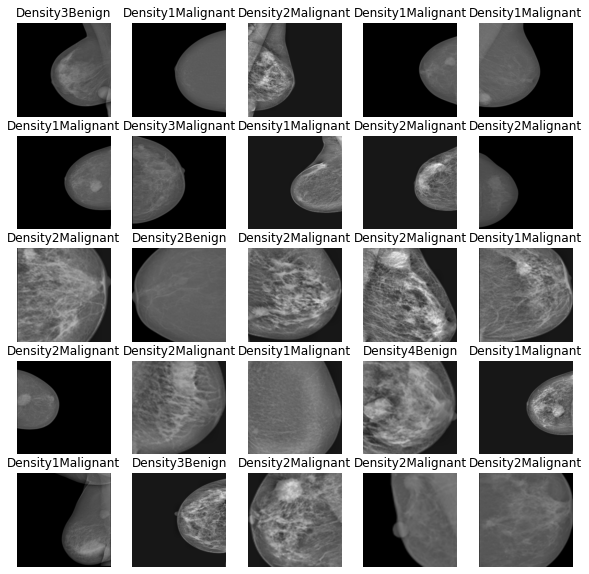

In [ ]:
train_data_crop_gen = image_generator.flow_from_directory(
        directory=str(data_crop_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(train_data_crop_gen)
show_batch(image_batch, label_batch)

## Horizontal flip Dataset

Found 340 images belonging to 8 classes.


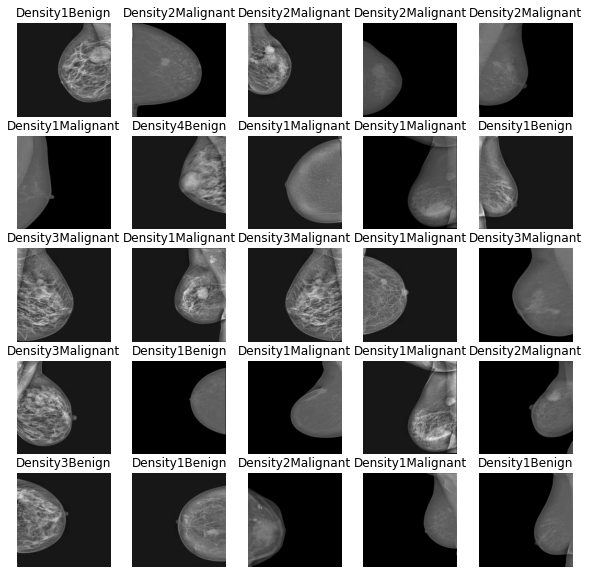

In [ ]:
train_data_hflip_gen = image_generator.flow_from_directory(
        directory=str(data_hflip_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(train_data_hflip_gen)
show_batch(image_batch, label_batch)

## Vertical flip Dataset

Found 340 images belonging to 8 classes.


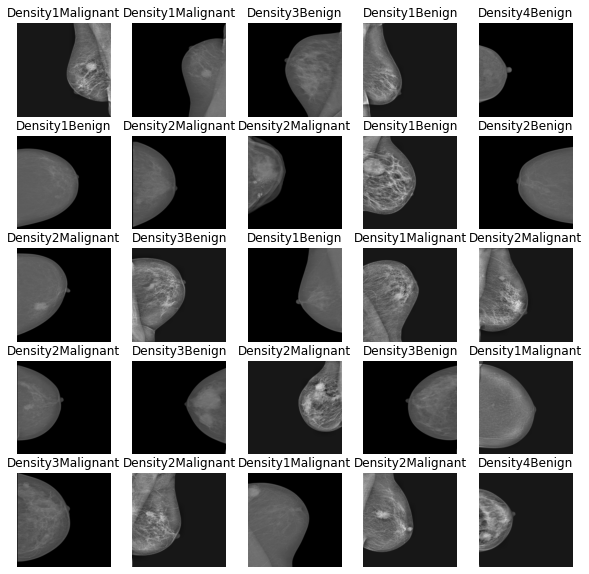

In [ ]:
train_data_vflip_gen = image_generator.flow_from_directory(
        directory=str(data_vflip_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(train_data_vflip_gen)
show_batch(image_batch, label_batch)

## Brightness Dataset

Found 340 images belonging to 8 classes.


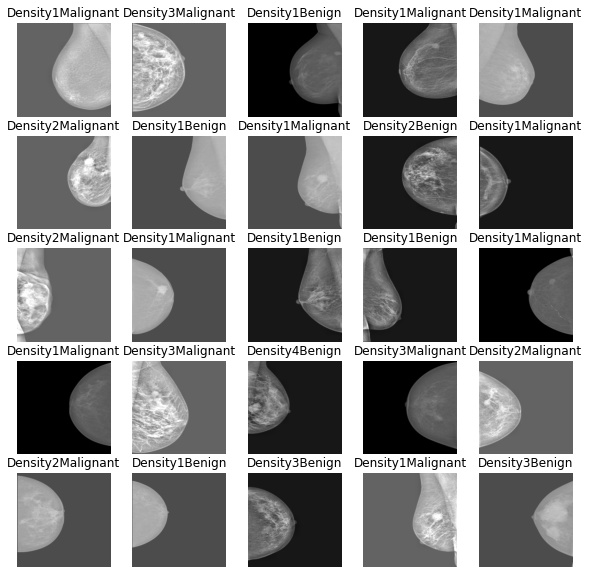

In [ ]:
train_data_brightness_gen = image_generator.flow_from_directory(
        directory=str(data_brightness_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(train_data_brightness_gen)
show_batch(image_batch, label_batch)

## Cropped and vertical flipped Dataset

Found 680 images belonging to 8 classes.


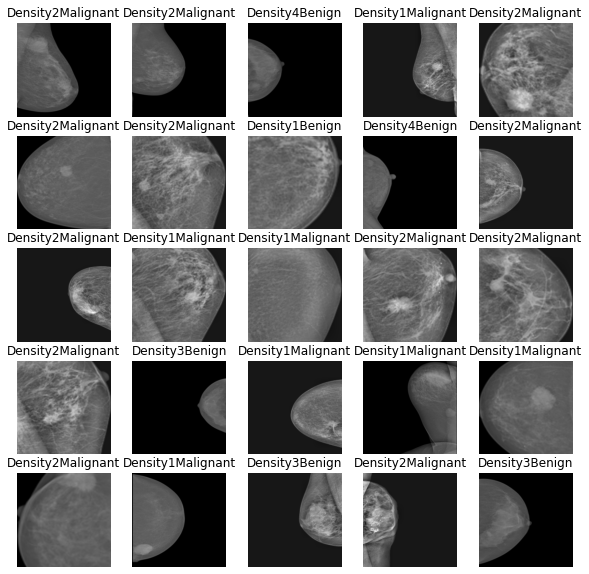

In [ ]:
train_data_crop_vflip_gen = image_generator.flow_from_directory(
        directory=str(data_crop_vflip_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(train_data_crop_vflip_gen)
show_batch(image_batch, label_batch)

## Cropped, vertical and horizontal flipped Dataset

Found 1360 images belonging to 8 classes.


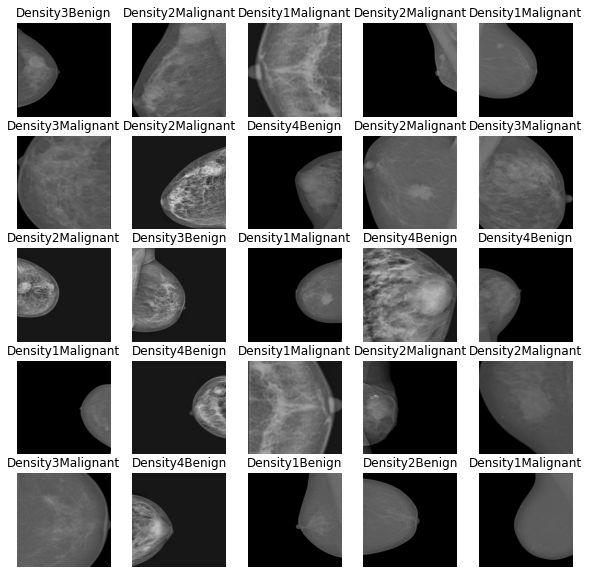

In [ ]:
train_data_crop_vhflip_gen = image_generator.flow_from_directory(
        directory=str(data_crop_vhflip_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(train_data_crop_vhflip_gen)
show_batch(image_batch, label_batch)

## Cropped, vertical and horizontal flipped and brightness Dataset

Found 2720 images belonging to 8 classes.


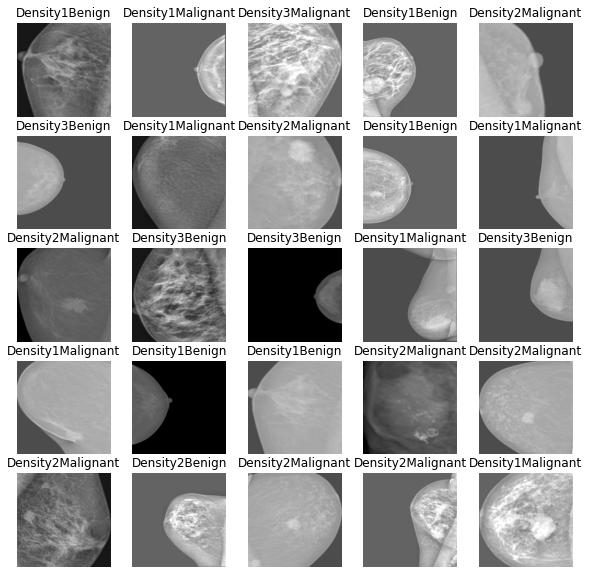

In [ ]:
train_data_crop_vflip_hflip_brightness_gen = image_generator.flow_from_directory(
        directory=str(crop_vflip_hflip_brightness_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(train_data_crop_vflip_hflip_brightness_gen)
show_batch(image_batch, label_batch)

## Vertical and horizontal flipped and brightness Testset

Found 344 images belonging to 8 classes.


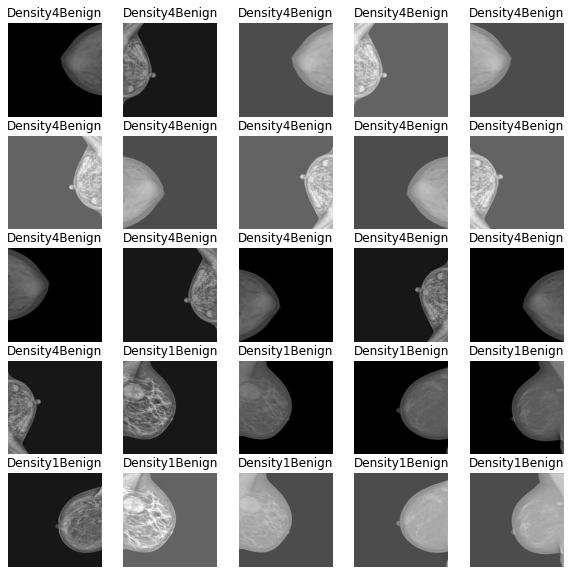

In [ ]:
val_vhflip_brightness_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Test/vflip_hflip_brightness"
val_data_vhflip_brightness_gen = image_generator.flow_from_directory(
        directory=val_vhflip_brightness_dir,
        batch_size=32,
        shuffle=False,
        target_size=(224, 224),
        # subset="validation",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(val_data_vhflip_brightness_gen)
show_batch(image_batch, label_batch)

# Inception

In [ ]:
def inception():
  base_model = tf.keras.applications.InceptionV3(
    include_top=False, input_tensor=None, input_shape=None,
    pooling=None, classes=len(CLASS_NAMES), classifier_activation='softmax') 
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu')(x)
  predictions = layers.Dense(train_data_gen.num_classes, activation='softmax')(x)
  return keras.Model(inputs=base_model.input, outputs=predictions)

## Train on plain Dataset

In [ ]:
inception = inception()
inception.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

In [ ]:
callbacks_inception = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("inception.h5", save_best_only=True),
]
inception.fit(train_data_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_inception)

Epoch 1/100
6/6 [==============================] - 8s 472ms/step - loss: 3.0348 - accuracy: 0.1618 - val_loss: 8.4824 - val_accuracy: 0.3023
Epoch 2/100
6/6 [==============================] - 2s 237ms/step - loss: 1.5856 - accuracy: 0.4368 - val_loss: 12.4794 - val_accuracy: 0.0698
Epoch 3/100
6/6 [==============================] - 2s 242ms/step - loss: 1.5488 - accuracy: 0.4870 - val_loss: 11.2452 - val_accuracy: 0.3023
Epoch 4/100
6/6 [==============================] - 1s 269ms/step - loss: 1.4011 - accuracy: 0.4303 - val_loss: 11.2452 - val_accuracy: 0.3023
Epoch 5/100
6/6 [==============================] - 1s 239ms/step - loss: 1.1209 - accuracy: 0.5904 - val_loss: 7.2417 - val_accuracy: 0.4186
Epoch 6/100
6/6 [==============================] - 1s 269ms/step - loss: 1.0624 - accuracy: 0.5740 - val_loss: 11.2937 - val_accuracy: 0.2791
Epoch 7/100
6/6 [==============================] - 1s 238ms/step - loss: 0.9575 - accuracy: 0.6958 - val_loss: 12.5966 - val_accuracy: 0.1163
Epoch 8/

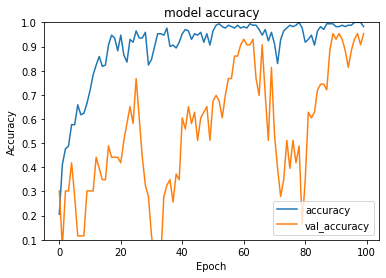

In [ ]:
plot_accuracy_graph(inception)

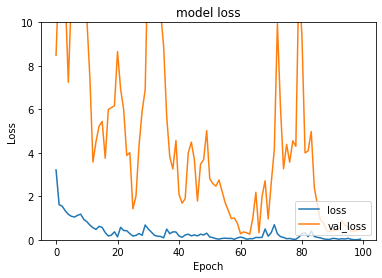

In [ ]:
plot_loss_graph(inception, 0, 10)

In [ ]:
try:
  best_inception = models.load_model("inception.h5")
except OSError as error:
  print(error)
  best_inception = loadmodel('best_inception')
best_inception.evaluate(val_data_gen)

2/2 [==============================] - 1s 51ms/step - loss: 0.2546 - accuracy: 0.9302


[0.2545655369758606, 0.930232584476471]

In [ ]:
savemodel(best_inception, 'best_inception')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception.h5



## Train on cropped Dataset

In [ ]:
inception_cropped = inception()
inception_cropped.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

In [ ]:
callbacks_inception_cropped = [
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("inception_crop.h5", save_best_only=True),
]
inception_cropped.fit(train_data_crop_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_inception_cropped)

Epoch 1/50
11/11 [==============================] - 10s 365ms/step - loss: 2.7994 - accuracy: 0.2115 - val_loss: 14.2381 - val_accuracy: 0.1163
Epoch 2/50
11/11 [==============================] - 3s 237ms/step - loss: 1.8265 - accuracy: 0.3679 - val_loss: 11.6200 - val_accuracy: 0.2791
Epoch 3/50
11/11 [==============================] - 3s 239ms/step - loss: 1.7287 - accuracy: 0.3891 - val_loss: 14.9936 - val_accuracy: 0.0698
Epoch 4/50
11/11 [==============================] - 3s 239ms/step - loss: 1.5861 - accuracy: 0.4888 - val_loss: 14.5109 - val_accuracy: 0.0698
Epoch 5/50
11/11 [==============================] - 3s 241ms/step - loss: 1.4370 - accuracy: 0.5037 - val_loss: 3.1850 - val_accuracy: 0.1860
Epoch 6/50
11/11 [==============================] - 3s 239ms/step - loss: 1.4685 - accuracy: 0.4770 - val_loss: 1.9537 - val_accuracy: 0.3721
Epoch 7/50
11/11 [==============================] - 3s 243ms/step - loss: 1.3079 - accuracy: 0.5238 - val_loss: 2.7607 - val_accuracy: 0.3256
E

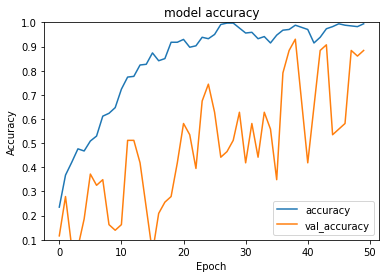

In [ ]:
plot_accuracy_graph(inception_cropped)

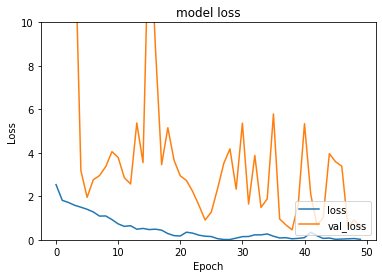

In [ ]:
plot_loss_graph(inception_cropped, 0, 10)

In [ ]:
try:
  best_inception_crop = models.load_model("inception_crop.h5")
except OSError as error:
  print(error)
  best_inception_crop = loadmodel('best_inception_cropped')
  
best_inception_crop.evaluate(val_data_gen)

2/2 [==============================] - 1s 51ms/step - loss: 0.4595 - accuracy: 0.9302


[0.45951125025749207, 0.930232584476471]

In [ ]:
savemodel(best_inception_crop, 'best_inception_crop')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception_crop.h5



## Train on horizontal flip Dataset

In [ ]:
inception_hflip = inception()
inception_hflip.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

In [ ]:
callbacks_inception_hflip = [
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("inception_hflip.h5", save_best_only=True),
]
inception_hflip.fit(train_data_hflip_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_inception_hflip)

Epoch 1/50
11/11 [==============================] - 10s 388ms/step - loss: 2.8466 - accuracy: 0.2220 - val_loss: 3.8698 - val_accuracy: 0.3023
Epoch 2/50
11/11 [==============================] - 3s 250ms/step - loss: 1.7718 - accuracy: 0.3598 - val_loss: 7.3845 - val_accuracy: 0.1395
Epoch 3/50
11/11 [==============================] - 3s 251ms/step - loss: 1.5785 - accuracy: 0.4599 - val_loss: 5.6609 - val_accuracy: 0.2791
Epoch 4/50
11/11 [==============================] - 3s 252ms/step - loss: 1.5875 - accuracy: 0.3914 - val_loss: 3.1979 - val_accuracy: 0.3721
Epoch 5/50
11/11 [==============================] - 3s 249ms/step - loss: 1.4216 - accuracy: 0.4547 - val_loss: 4.4343 - val_accuracy: 0.2791
Epoch 6/50
11/11 [==============================] - 3s 250ms/step - loss: 1.0714 - accuracy: 0.6282 - val_loss: 1.6174 - val_accuracy: 0.3488
Epoch 7/50
11/11 [==============================] - 3s 250ms/step - loss: 1.0553 - accuracy: 0.6285 - val_loss: 3.5744 - val_accuracy: 0.2093
Epoch

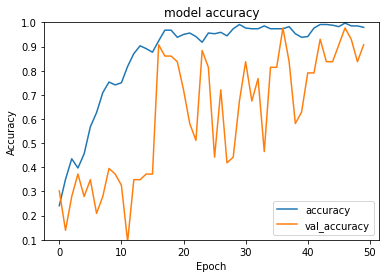

In [ ]:
plot_accuracy_graph(inception_hflip)

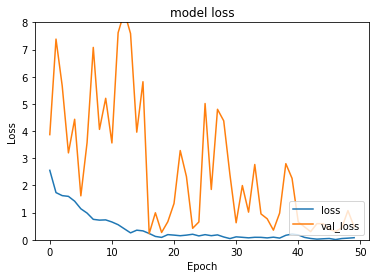

In [ ]:
plot_loss_graph(inception_hflip, 0, 8)

In [ ]:
try:
  best_inception_hflip = models.load_model("inception_hflip.h5")
except OSError as error:
  print(error)
  best_inception_hflip = loadmodel('best_inception_hflip')

best_inception_hflip.evaluate(val_data_gen)

2/2 [==============================] - 1s 53ms/step - loss: 0.2274 - accuracy: 0.9070


[0.2273889183998108, 0.9069767594337463]

In [ ]:
savemodel(best_inception_hflip, 'best_inception_hflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception_hflip.h5



## Train on vertical flip Dataset

In [ ]:
inception_vflip = inception()
inception_vflip.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

In [ ]:
callbacks_inception_vflip = [
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("inception_vflip.h5", save_best_only=True),
]
inception_vflip.fit(train_data_vflip_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_inception_vflip)

Epoch 1/50
11/11 [==============================] - 10s 365ms/step - loss: 2.5039 - accuracy: 0.2468 - val_loss: 5.7616 - val_accuracy: 0.3953
Epoch 2/50
11/11 [==============================] - 3s 251ms/step - loss: 1.5837 - accuracy: 0.4612 - val_loss: 11.2452 - val_accuracy: 0.3023
Epoch 3/50
11/11 [==============================] - 3s 253ms/step - loss: 1.2196 - accuracy: 0.5832 - val_loss: 8.0611 - val_accuracy: 0.2558
Epoch 4/50
11/11 [==============================] - 3s 253ms/step - loss: 1.0730 - accuracy: 0.6092 - val_loss: 11.6200 - val_accuracy: 0.2791
Epoch 5/50
11/11 [==============================] - 3s 253ms/step - loss: 0.8245 - accuracy: 0.7096 - val_loss: 11.6200 - val_accuracy: 0.2791
Epoch 6/50
11/11 [==============================] - 3s 254ms/step - loss: 0.5914 - accuracy: 0.8072 - val_loss: 11.6200 - val_accuracy: 0.2791
Epoch 7/50
11/11 [==============================] - 3s 253ms/step - loss: 0.4624 - accuracy: 0.8278 - val_loss: 7.5185 - val_accuracy: 0.3023
E

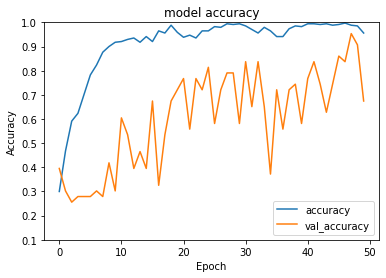

In [ ]:
plot_accuracy_graph(inception_vflip)

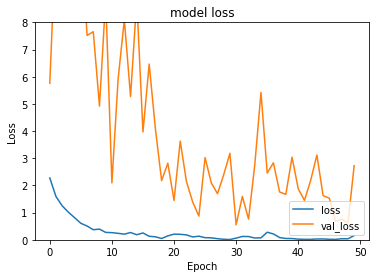

In [ ]:
plot_loss_graph(inception_vflip, 0, 8)

In [ ]:
try:
  best_inception_vflip = models.load_model("inception_vflip.h5")
except OSError as error:
  print(error)
  best_inception_vflip = loadmodel('best_inception_vflip')
  
best_inception_vflip.evaluate(val_data_gen)

2/2 [==============================] - 1s 50ms/step - loss: 0.5519 - accuracy: 0.8372


[0.5518697500228882, 0.8372092843055725]

In [ ]:
savemodel(best_inception_vflip, 'best_inception_vflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception_vflip.h5



## Train on brightness Dataset

In [ ]:
inception_brightness = inception()
inception_brightness.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

In [ ]:
callbacks_inception_brightness = [
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("inception_brightness.h5", save_best_only=True),
]
inception_brightness.fit(train_data_brightness_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_inception_brightness)

Epoch 1/50
11/11 [==============================] - 10s 389ms/step - loss: 2.9254 - accuracy: 0.2831 - val_loss: 1.9732 - val_accuracy: 0.1395
Epoch 2/50
11/11 [==============================] - 3s 253ms/step - loss: 1.5269 - accuracy: 0.4927 - val_loss: 8.1963 - val_accuracy: 0.2791
Epoch 3/50
11/11 [==============================] - 3s 253ms/step - loss: 1.3011 - accuracy: 0.5582 - val_loss: 8.1184 - val_accuracy: 0.0465
Epoch 4/50
11/11 [==============================] - 3s 253ms/step - loss: 0.8397 - accuracy: 0.7316 - val_loss: 5.4708 - val_accuracy: 0.3953
Epoch 5/50
11/11 [==============================] - 3s 255ms/step - loss: 0.5851 - accuracy: 0.7850 - val_loss: 10.5107 - val_accuracy: 0.1163
Epoch 6/50
11/11 [==============================] - 3s 263ms/step - loss: 0.4174 - accuracy: 0.8892 - val_loss: 2.8086 - val_accuracy: 0.2326
Epoch 7/50
11/11 [==============================] - 3s 256ms/step - loss: 0.2689 - accuracy: 0.9064 - val_loss: 6.6296 - val_accuracy: 0.1860
Epoc

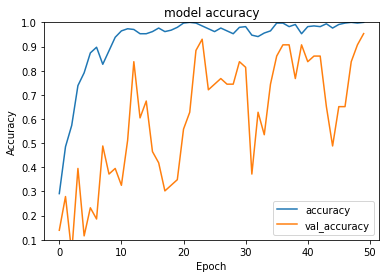

In [ ]:
plot_accuracy_graph(inception_brightness)

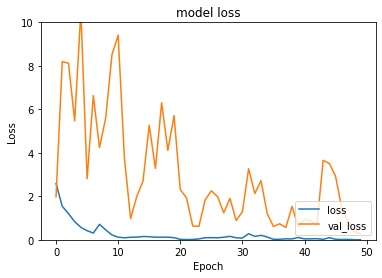

In [ ]:
plot_loss_graph(inception_brightness, 0, 10)

In [ ]:
try:
  best_inception_brightness = models.load_model("inception_brightness.h5")
except OSError as error:
  print(error)
  best_inception_brightness = loadmodel('best_inception_brightness')

best_inception_brightness.evaluate(val_data_gen)

2/2 [==============================] - 1s 46ms/step - loss: 0.2834 - accuracy: 0.9535


[0.2833547592163086, 0.9534883499145508]

In [ ]:
savemodel(best_inception_brightness, 'best_inception_brightness')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception_brightness.h5



##Train on cropped and vertical flip Dataset

In [ ]:
inception_crop_vflip = inception()
inception_crop_vflip.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

In [ ]:
callbacks_inception_crop_vflip = [
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("inception_crop_vflip.h5", save_best_only=True),
]
inception_crop_vflip.fit(train_data_crop_vflip_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_inception_crop_vflip)

Epoch 1/50
22/22 [==============================] - 13s 302ms/step - loss: 2.3549 - accuracy: 0.2982 - val_loss: 9.9247 - val_accuracy: 0.2791
Epoch 2/50
22/22 [==============================] - 5s 244ms/step - loss: 1.6204 - accuracy: 0.4258 - val_loss: 11.5427 - val_accuracy: 0.2791
Epoch 3/50
22/22 [==============================] - 5s 245ms/step - loss: 1.5757 - accuracy: 0.4467 - val_loss: 8.9479 - val_accuracy: 0.3023
Epoch 4/50
22/22 [==============================] - 5s 243ms/step - loss: 1.4689 - accuracy: 0.4945 - val_loss: 4.4346 - val_accuracy: 0.2326
Epoch 5/50
22/22 [==============================] - 5s 244ms/step - loss: 1.1635 - accuracy: 0.5940 - val_loss: 2.9702 - val_accuracy: 0.1163
Epoch 6/50
22/22 [==============================] - 5s 252ms/step - loss: 0.9382 - accuracy: 0.6741 - val_loss: 2.2635 - val_accuracy: 0.2558
Epoch 7/50
22/22 [==============================] - 5s 244ms/step - loss: 0.7188 - accuracy: 0.7486 - val_loss: 7.1971 - val_accuracy: 0.0698
Epoc

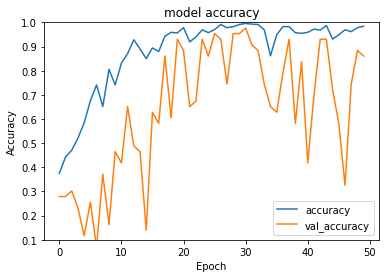

In [ ]:
plot_accuracy_graph(inception_crop_vflip)

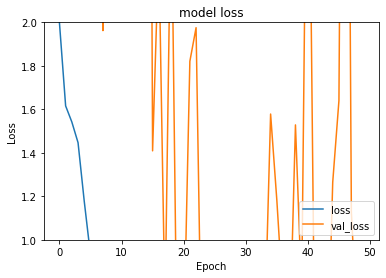

In [ ]:
plot_loss_graph(inception_crop_vflip, 0, 6)

In [ ]:
try:
  best_inception_crop_vflip = models.load_model("inception_crop_vflip.h5")
except OSError as error:
  print(error)
  best_inception_crop_vflip = loadmodel('best_inception_crop_vflip')

best_inception_crop_vflip.evaluate(val_data_gen)

2/2 [==============================] - 1s 44ms/step - loss: 0.1954 - accuracy: 0.9302


[0.19538196921348572, 0.930232584476471]

In [ ]:
savemodel(best_inception_crop_vflip, 'best_inception_crop_vflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception_crop_vflip.h5



## Train on cropped, vertical and horizontal flip Dataset

In [ ]:
inception_crop_vhflip = inception()
inception_crop_vhflip.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

In [ ]:
callbacks_inception_crop_vhflip = [
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("inception_crop_vhflip.h5", save_best_only=True),
]
inception_crop_vhflip.fit(train_data_crop_vhflip_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_inception_crop_vhflip)

Epoch 1/50
43/43 [==============================] - 18s 274ms/step - loss: 2.0445 - accuracy: 0.2830 - val_loss: 3.2354 - val_accuracy: 0.2791
Epoch 2/50
43/43 [==============================] - 11s 250ms/step - loss: 1.7331 - accuracy: 0.3241 - val_loss: 10.9628 - val_accuracy: 0.3023
Epoch 3/50
43/43 [==============================] - 11s 251ms/step - loss: 1.6740 - accuracy: 0.3495 - val_loss: 11.2452 - val_accuracy: 0.3023
Epoch 4/50
43/43 [==============================] - 11s 247ms/step - loss: 1.7407 - accuracy: 0.3386 - val_loss: 4.1989 - val_accuracy: 0.3488
Epoch 5/50
43/43 [==============================] - 11s 246ms/step - loss: 1.6521 - accuracy: 0.3674 - val_loss: 5.4949 - val_accuracy: 0.2791
Epoch 6/50
43/43 [==============================] - 11s 246ms/step - loss: 1.7138 - accuracy: 0.3408 - val_loss: 2.3301 - val_accuracy: 0.3721
Epoch 7/50
43/43 [==============================] - 11s 246ms/step - loss: 1.5292 - accuracy: 0.4335 - val_loss: 6.0254 - val_accuracy: 0.23

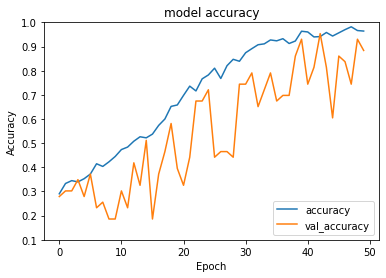

In [ ]:
plot_accuracy_graph(inception_crop_vhflip)

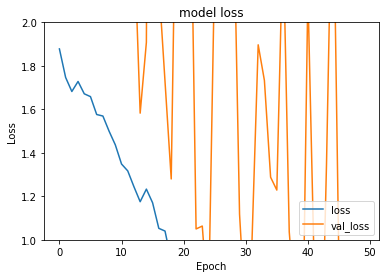

In [ ]:
plot_loss_graph(inception_crop_vhflip, 0, 6)

In [ ]:
try:
  best_inception_crop_vhflip = models.load_model("inception_crop_vhflip.h5")
except OSError as error:
  print(error)
  best_inception_crop_vhflip = loadmodel('best_inception_crop_vhflip')

best_inception_crop_vhflip.evaluate(val_data_gen)

2/2 [==============================] - 1s 47ms/step - loss: 0.1640 - accuracy: 0.9535


[0.16400296986103058, 0.9534883499145508]

In [ ]:
savemodel(best_inception_crop_vhflip, 'best_inception_crop_vhflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception_crop_vhflip.h5



## Train on cropped, vertical, horizontal and brightness Dataset

In [ ]:
inception_crop_vhflip_brightness = inception()
inception_crop_vhflip_brightness.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
callbacks_inception_crop_vhflip_brightness = [
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("inception_crop_vhflip_brigthtness.h5", save_best_only=True),
]
inception_crop_vhflip_brightness.fit(train_data_crop_vflip_hflip_brightness_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_inception_crop_vhflip_brightness)

Epoch 1/50
85/85 [==============================] - 539s 6s/step - loss: 1.9154 - accuracy: 0.3076 - val_loss: 1.9351 - val_accuracy: 0.3023
Epoch 2/50
85/85 [==============================] - 20s 235ms/step - loss: 1.3281 - accuracy: 0.4715 - val_loss: 7.0978 - val_accuracy: 0.2791
Epoch 3/50
85/85 [==============================] - 20s 240ms/step - loss: 1.0069 - accuracy: 0.6194 - val_loss: 4.3611 - val_accuracy: 0.3721
Epoch 4/50
85/85 [==============================] - 21s 244ms/step - loss: 0.5762 - accuracy: 0.8020 - val_loss: 2.9820 - val_accuracy: 0.5116
Epoch 5/50
85/85 [==============================] - 21s 240ms/step - loss: 0.3002 - accuracy: 0.9018 - val_loss: 1.5151 - val_accuracy: 0.6279
Epoch 6/50
85/85 [==============================] - 20s 239ms/step - loss: 0.1711 - accuracy: 0.9485 - val_loss: 0.8328 - val_accuracy: 0.8140
Epoch 7/50
85/85 [==============================] - 21s 242ms/step - loss: 0.1910 - accuracy: 0.9310 - val_loss: 0.5029 - val_accuracy: 0.8372
E

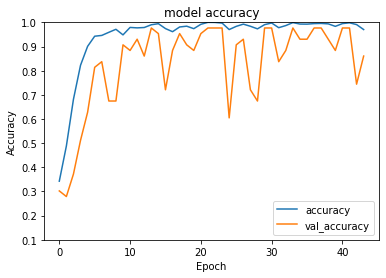

In [ ]:
plot_accuracy_graph(inception_crop_vhflip_brightness)

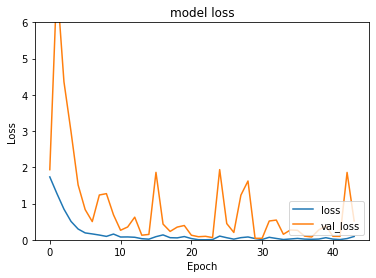

In [ ]:
plot_loss_graph(inception_crop_vhflip_brightness, 0, 6)

In [ ]:
try:
  best_inception_crop_vhflip_brigthtness = models.load_model("inception_crop_vhflip_brightness.h5")
except OSError as error:
  print(error)
  best_inception_crop_vhflip_brigthtness = loadmodel('inception_crop_vhflip_brightness')
  
best_inception_crop_vhflip_brigthtness.evaluate(val_data_gen)

SavedModel file does not exist at: inception_crop_vhflip_brightness.h5/{saved_model.pbtxt|saved_model.pb}

Model loaded successfully from file /content/drive/MyDrive/Colab Notebooks/models/inception_crop_vhflip_brightness.h5

2/2 [==============================] - 1s 45ms/step - loss: 0.0799 - accuracy: 0.9767


[0.07991606742143631, 0.9767441749572754]

In [ ]:
best_inception_crop_vhflip_brigthtness.evaluate(val_data_vhflip_brightness_gen)

11/11 [==============================] - 51s 5s/step - loss: 0.2765 - accuracy: 0.9157


[0.27649959921836853, 0.9156976938247681]

In [ ]:
preds = best_inception_crop_vhflip_brigthtness.predict(val_data_vhflip_brightness_gen,verbose=1)

Ypred = np.argmax(preds, axis=1)
Ytest = val_data_vhflip_brightness_gen.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=CLASS_NAMES, digits=3))

11/11 [==============================] - 2s 97ms/step
                   precision    recall  f1-score   support

   Density4Benign      0.593     1.000     0.744        16
   Density1Benign      1.000     1.000     1.000        40
Density3Malignant      0.852     0.958     0.902        24
   Density3Benign      0.941     0.800     0.865        40
Density4Malignant      1.000     1.000     1.000         8
   Density2Benign      0.889     1.000     0.941        16
Density1Malignant      0.966     0.896     0.930        96
Density2Malignant      0.931     0.904     0.917       104

         accuracy                          0.916       344
        macro avg      0.896     0.945     0.912       344
     weighted avg      0.928     0.916     0.918       344



[[16  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0]
 [ 0  0 23  1  0  0  0  0]
 [ 5  0  1 32  0  0  0  2]
 [ 0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0 16  0  0]
 [ 0  0  3  0  0  2 86  5]
 [ 6  0  0  1  0  0  3 94]]


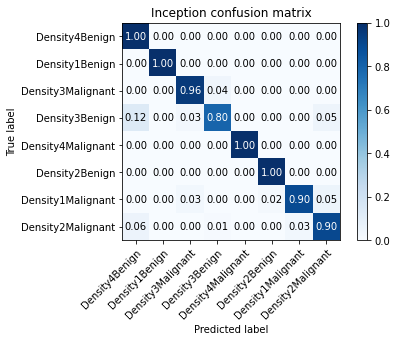

In [ ]:
cm = confusion_matrix(Ytest, Ypred, labels=None)
print(cm)
plot_confusion_matrix(Ytest, Ypred, classes=np.asarray(CLASS_NAMES), normalize=True, title='Inception confusion matrix')

In [ ]:
savemodel(best_inception_crop_vhflip_brigthtness, 'best_inception_crop_vhflip_brightness')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception_crop_vhflip_brightness.h5



# VGG19

In [ ]:
# VGG
def VGG():
  base_model = tf.keras.applications.VGG19(include_top=False, input_tensor=None, input_shape=None,
    pooling=None, classes=len(CLASS_NAMES), classifier_activation='softmax') 
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu')(x)
  predictions = layers.Dense(train_data_gen.num_classes, activation='softmax')(x)
  return keras.Model(inputs=base_model.input, outputs=predictions)

## Train on plain Dataset

In [ ]:
VGG = VGG()
VGG.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_vgg = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("vgg.h5", save_best_only=True),
]

VGG.fit(train_data_gen, epochs=100, 
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg)

Epoch 1/100
6/6 [==============================] - 4s 558ms/step - loss: 1.9546 - accuracy: 0.2033 - val_loss: 1.8349 - val_accuracy: 0.2791
Epoch 2/100
6/6 [==============================] - 3s 513ms/step - loss: 1.8036 - accuracy: 0.2863 - val_loss: 1.7679 - val_accuracy: 0.2791
Epoch 3/100
6/6 [==============================] - 3s 512ms/step - loss: 1.6764 - accuracy: 0.3521 - val_loss: 1.7523 - val_accuracy: 0.3488
Epoch 4/100
6/6 [==============================] - 3s 514ms/step - loss: 1.7188 - accuracy: 0.4124 - val_loss: 1.7571 - val_accuracy: 0.3953
Epoch 5/100
6/6 [==============================] - 3s 523ms/step - loss: 1.6637 - accuracy: 0.4396 - val_loss: 1.7695 - val_accuracy: 0.3023
Epoch 6/100
6/6 [==============================] - 3s 592ms/step - loss: 1.6679 - accuracy: 0.4008 - val_loss: 1.7298 - val_accuracy: 0.4186
Epoch 7/100
6/6 [==============================] - 3s 536ms/step - loss: 1.6994 - accuracy: 0.4222 - val_loss: 1.7143 - val_accuracy: 0.3721
Epoch 8/100
6

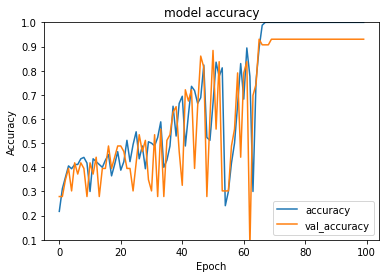

In [ ]:
plot_accuracy_graph(VGG)

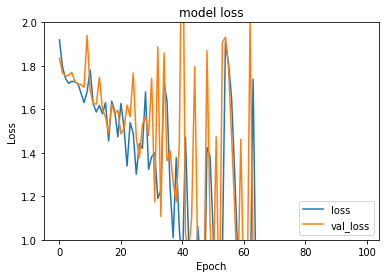

In [ ]:
plot_loss_graph(VGG, 1, 2)

In [ ]:
try:
  best_vgg = models.load_model("vgg.h5")
except OSError as error:
  print(error)
  best_vgg = loadmodel('best_vgg')
  
best_vgg.evaluate(val_data_gen)

2/2 [==============================] - 1s 76ms/step - loss: 0.4396 - accuracy: 0.9070


[0.43964165449142456, 0.9069767594337463]

In [ ]:
savemodel(best_vgg, 'best_vgg')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg.h5



## Train on cropped Dataset

In [ ]:
vgg_cropped = VGG()
vgg_cropped.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_vgg_crop = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("vgg_crop.h5", save_best_only=True),
]

vgg_cropped.fit(train_data_crop_gen, epochs=100,
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg_crop)

Epoch 1/100
11/11 [==============================] - 9s 750ms/step - loss: 2.0016 - accuracy: 0.2296 - val_loss: 1.8823 - val_accuracy: 0.3023
Epoch 2/100
11/11 [==============================] - 5s 488ms/step - loss: 1.8094 - accuracy: 0.3316 - val_loss: 1.7531 - val_accuracy: 0.3721
Epoch 3/100
11/11 [==============================] - 5s 488ms/step - loss: 1.7236 - accuracy: 0.3950 - val_loss: 1.7679 - val_accuracy: 0.3953
Epoch 4/100
11/11 [==============================] - 5s 491ms/step - loss: 1.7250 - accuracy: 0.3659 - val_loss: 1.7616 - val_accuracy: 0.3488
Epoch 5/100
11/11 [==============================] - 5s 494ms/step - loss: 1.7220 - accuracy: 0.3952 - val_loss: 1.7423 - val_accuracy: 0.3721
Epoch 6/100
11/11 [==============================] - 5s 494ms/step - loss: 1.7583 - accuracy: 0.3734 - val_loss: 1.7116 - val_accuracy: 0.3488
Epoch 7/100
11/11 [==============================] - 5s 507ms/step - loss: 1.6524 - accuracy: 0.4329 - val_loss: 1.7284 - val_accuracy: 0.3721

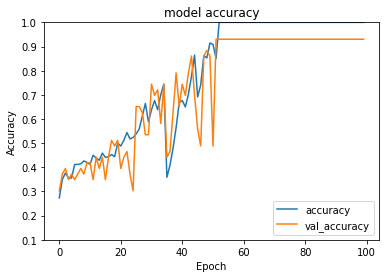

In [ ]:
plot_accuracy_graph(vgg_cropped)

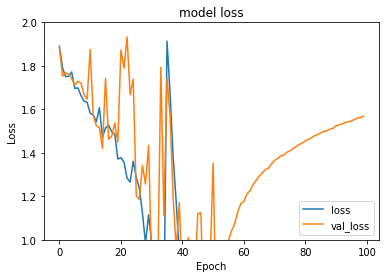

In [ ]:
plot_loss_graph(vgg_cropped, 1, 2)

In [ ]:
try:
  best_vgg_crop = models.load_model("vgg_crop.h5")
except OSError as error:
  print(error)
  best_vgg_crop = loadmodel('best_vgg_cropped')

best_vgg_crop.evaluate(val_data_gen)

2/2 [==============================] - 0s 74ms/step - loss: 0.6414 - accuracy: 0.9302


[0.6413601040840149, 0.930232584476471]

In [ ]:
savemodel(best_vgg_crop, 'best_vgg_crop')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg_crop.h5



## Train on horizontal flip Dataset

In [ ]:
vgg_hflip = VGG()
vgg_hflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_vgg_hflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("vgg_hflip.h5", save_best_only=True),
]

vgg_hflip.fit(train_data_hflip_gen, epochs=100,
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg_hflip)

Epoch 1/100
11/11 [==============================] - 7s 548ms/step - loss: 1.9204 - accuracy: 0.2387 - val_loss: 1.8177 - val_accuracy: 0.3023
Epoch 2/100
11/11 [==============================] - 6s 537ms/step - loss: 1.7773 - accuracy: 0.3034 - val_loss: 1.7665 - val_accuracy: 0.3953
Epoch 3/100
11/11 [==============================] - 6s 531ms/step - loss: 1.7871 - accuracy: 0.2903 - val_loss: 1.7808 - val_accuracy: 0.3023
Epoch 4/100
11/11 [==============================] - 6s 533ms/step - loss: 1.7424 - accuracy: 0.3024 - val_loss: 1.7476 - val_accuracy: 0.3488
Epoch 5/100
11/11 [==============================] - 6s 532ms/step - loss: 1.7354 - accuracy: 0.3444 - val_loss: 1.7421 - val_accuracy: 0.3023
Epoch 6/100
11/11 [==============================] - 6s 534ms/step - loss: 1.7035 - accuracy: 0.3614 - val_loss: 1.7265 - val_accuracy: 0.3721
Epoch 7/100
11/11 [==============================] - 6s 536ms/step - loss: 1.7245 - accuracy: 0.3325 - val_loss: 1.7084 - val_accuracy: 0.3953

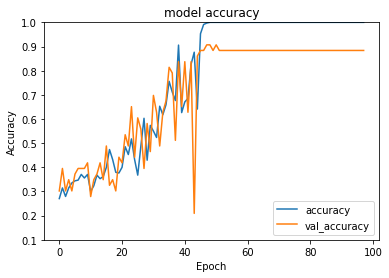

In [ ]:
plot_accuracy_graph(vgg_hflip)

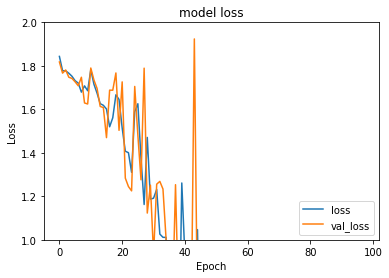

In [ ]:
plot_loss_graph(vgg_hflip, 1, 2)

In [ ]:
try:
  best_vgg_hflip = models.load_model("vgg_hflip.h5")
except OSError as error:
  print(error)
  best_vgg_hflip = loadmodel('best_vgg_hflip')

best_vgg_hflip.evaluate(val_data_gen)

2/2 [==============================] - 0s 72ms/step - loss: 0.3176 - accuracy: 0.9070


[0.31758105754852295, 0.9069767594337463]

In [ ]:
savemodel(best_vgg_hflip, 'best_vgg_hflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg_hflip.h5



## Train on vertical flip Dataset

In [ ]:
vgg_vflip = VGG()
vgg_vflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_vgg_vflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("vgg_vflip.h5", save_best_only=True),
]

vgg_vflip.fit(train_data_vflip_gen, epochs=100,
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg_vflip)

Epoch 1/100
11/11 [==============================] - 8s 546ms/step - loss: 1.9073 - accuracy: 0.2266 - val_loss: 1.7707 - val_accuracy: 0.2791
Epoch 2/100
11/11 [==============================] - 6s 524ms/step - loss: 1.7476 - accuracy: 0.2887 - val_loss: 1.7395 - val_accuracy: 0.3488
Epoch 3/100
11/11 [==============================] - 6s 532ms/step - loss: 1.6957 - accuracy: 0.3830 - val_loss: 1.7252 - val_accuracy: 0.4186
Epoch 4/100
11/11 [==============================] - 6s 542ms/step - loss: 1.6632 - accuracy: 0.4037 - val_loss: 1.7279 - val_accuracy: 0.4419
Epoch 5/100
11/11 [==============================] - 6s 546ms/step - loss: 1.6887 - accuracy: 0.3951 - val_loss: 1.7742 - val_accuracy: 0.3488
Epoch 6/100
11/11 [==============================] - 6s 542ms/step - loss: 1.6364 - accuracy: 0.4337 - val_loss: 1.6733 - val_accuracy: 0.4186
Epoch 7/100
11/11 [==============================] - 6s 534ms/step - loss: 1.6124 - accuracy: 0.4440 - val_loss: 1.6177 - val_accuracy: 0.3953

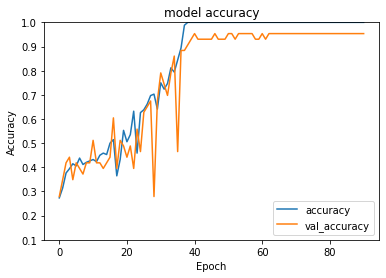

In [ ]:
plot_accuracy_graph(vgg_vflip)

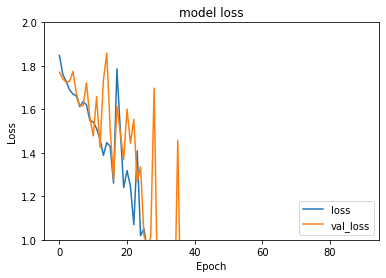

In [ ]:
plot_loss_graph(vgg_vflip, 1, 2)

In [ ]:
try:
  best_vgg_vflip = models.load_model("vgg_vflip.h5")
except OSError as error:
  print(error)
  best_vgg_vflip = loadmodel('best_vgg_vflip')

best_vgg_vflip.evaluate(val_data_gen)

2/2 [==============================] - 1s 77ms/step - loss: 0.4109 - accuracy: 0.8837


[0.4109228253364563, 0.8837209343910217]

In [ ]:
savemodel(best_vgg_vflip, 'best_vgg_vflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg_vflip.h5



## Train on brightness Dataset

In [ ]:
vgg_brightness = VGG()
vgg_brightness.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_vgg_brightness = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("vgg_brightness.h5", save_best_only=True),
]

vgg_brightness.fit(train_data_brightness_gen, epochs=100,
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg_brightness)

Epoch 1/100
11/11 [==============================] - 7s 548ms/step - loss: 1.9605 - accuracy: 0.2250 - val_loss: 1.7747 - val_accuracy: 0.3023
Epoch 2/100
11/11 [==============================] - 6s 524ms/step - loss: 1.7685 - accuracy: 0.3548 - val_loss: 1.7602 - val_accuracy: 0.3488
Epoch 3/100
11/11 [==============================] - 6s 531ms/step - loss: 1.7169 - accuracy: 0.3814 - val_loss: 1.7527 - val_accuracy: 0.3721
Epoch 4/100
11/11 [==============================] - 6s 538ms/step - loss: 1.7156 - accuracy: 0.3702 - val_loss: 1.6850 - val_accuracy: 0.3721
Epoch 5/100
11/11 [==============================] - 6s 543ms/step - loss: 1.6378 - accuracy: 0.4079 - val_loss: 1.6542 - val_accuracy: 0.3953
Epoch 6/100
11/11 [==============================] - 6s 541ms/step - loss: 1.5840 - accuracy: 0.4330 - val_loss: 1.8232 - val_accuracy: 0.4419
Epoch 7/100
11/11 [==============================] - 6s 537ms/step - loss: 1.6033 - accuracy: 0.4248 - val_loss: 1.5815 - val_accuracy: 0.4419

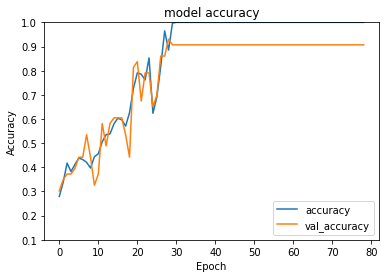

In [ ]:
plot_accuracy_graph(vgg_brightness)

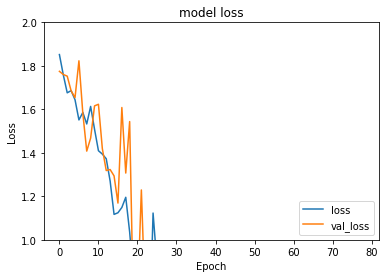

In [ ]:
plot_loss_graph(vgg_brightness, 1, 2)

In [ ]:
try:
  best_vgg_brightness = models.load_model("vgg_brightness.h5")
except OSError as error:
  print(error)
  best_vgg_brightness = loadmodel('best_vgg_brightness')

best_vgg_brightness.evaluate(val_data_gen)

2/2 [==============================] - 1s 74ms/step - loss: 0.4140 - accuracy: 0.9302


[0.4140382409095764, 0.930232584476471]

In [ ]:
savemodel(best_vgg_brightness, 'best_vgg_brightness')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg_brightness.h5



## Train on cropped and vertical flip Dataset

In [ ]:
vgg_crop_vflip = VGG()
vgg_crop_vflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_vgg_crop_vflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("vgg_crop_vflip.h5", save_best_only=True),
]

vgg_crop_vflip.fit(train_data_crop_vflip_gen, epochs=50,
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg_crop_vflip)

Epoch 1/50
22/22 [==============================] - 14s 591ms/step - loss: 1.9321 - accuracy: 0.2322 - val_loss: 1.7724 - val_accuracy: 0.3721
Epoch 2/50
22/22 [==============================] - 11s 516ms/step - loss: 1.7581 - accuracy: 0.3607 - val_loss: 1.7539 - val_accuracy: 0.3953
Epoch 3/50
22/22 [==============================] - 11s 518ms/step - loss: 1.7375 - accuracy: 0.3365 - val_loss: 1.7361 - val_accuracy: 0.3953
Epoch 4/50
22/22 [==============================] - 12s 522ms/step - loss: 1.6953 - accuracy: 0.3713 - val_loss: 1.7017 - val_accuracy: 0.3721
Epoch 5/50
22/22 [==============================] - 12s 520ms/step - loss: 1.6251 - accuracy: 0.4148 - val_loss: 1.7409 - val_accuracy: 0.3721
Epoch 6/50
22/22 [==============================] - 11s 519ms/step - loss: 1.6198 - accuracy: 0.4017 - val_loss: 1.6085 - val_accuracy: 0.3953
Epoch 7/50
22/22 [==============================] - 12s 520ms/step - loss: 1.5387 - accuracy: 0.4540 - val_loss: 1.6265 - val_accuracy: 0.3488

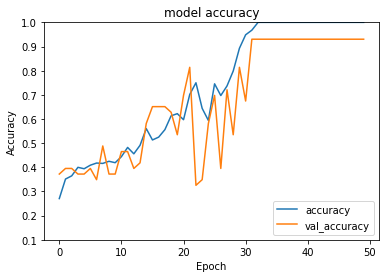

In [ ]:
plot_accuracy_graph(vgg_crop_vflip)

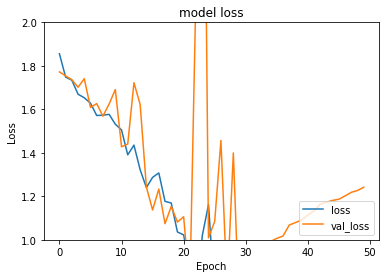

In [ ]:
plot_loss_graph(vgg_crop_vflip, 0, 3)

In [ ]:
try:
  best_vgg_crop_vflip = models.load_model("vgg_crop_vflip.h5")
except OSError as error:
  print(error)
  best_vgg_crop_vflip = loadmodel('best_vgg_crop_vflip')

best_vgg_crop_vflip.evaluate(val_data_gen)

2/2 [==============================] - 1s 74ms/step - loss: 0.6216 - accuracy: 0.8140


[0.6215769648551941, 0.8139534592628479]

In [ ]:
savemodel(best_vgg_crop_vflip, 'best_vgg_crop_vflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg_crop_vflip.h5



## Train on cropped, vertical and horizontal flip Dataset

In [ ]:
vgg_crop_vhflip = VGG()
vgg_crop_vhflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_vgg_crop_vhflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("vgg_crop_vhflip.h5", save_best_only=True),
]

vgg_crop_vhflip.fit(train_data_crop_vhflip_gen, epochs=50,
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg_crop_vhflip)

Epoch 1/50
43/43 [==============================] - 25s 573ms/step - loss: 1.8412 - accuracy: 0.2612 - val_loss: 1.8368 - val_accuracy: 0.2791
Epoch 2/50
43/43 [==============================] - 23s 521ms/step - loss: 1.7677 - accuracy: 0.3224 - val_loss: 1.7596 - val_accuracy: 0.3488
Epoch 3/50
43/43 [==============================] - 22s 517ms/step - loss: 1.7461 - accuracy: 0.3097 - val_loss: 1.7790 - val_accuracy: 0.3953
Epoch 4/50
43/43 [==============================] - 22s 515ms/step - loss: 1.7405 - accuracy: 0.3284 - val_loss: 1.6976 - val_accuracy: 0.3488
Epoch 5/50
43/43 [==============================] - 22s 517ms/step - loss: 1.7134 - accuracy: 0.3453 - val_loss: 1.6260 - val_accuracy: 0.4419
Epoch 6/50
43/43 [==============================] - 22s 519ms/step - loss: 1.6559 - accuracy: 0.3394 - val_loss: 1.7076 - val_accuracy: 0.4651
Epoch 7/50
43/43 [==============================] - 22s 521ms/step - loss: 1.6917 - accuracy: 0.3352 - val_loss: 2.0245 - val_accuracy: 0.3256

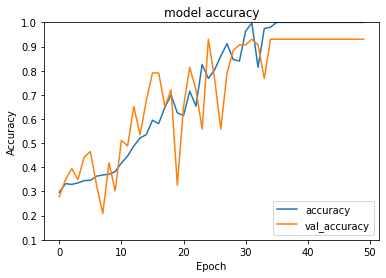

In [ ]:
plot_accuracy_graph(vgg_crop_vhflip)

In [ ]:
plot_loss_graph(vgg_crop_vhflip, 0, 3)

NameError: ignored

In [ ]:
try:
  best_vgg_crop_vhflip = models.load_model("vgg_crop_vhflip.h5")
except OSError as error:
  print(error)
  best_vgg_crop_vhflip = loadmodel('best_vgg_crop_vhflip')

best_vgg_crop_vhflip.evaluate(val_data_gen)

2/2 [==============================] - 1s 74ms/step - loss: 0.3010 - accuracy: 0.9070


[0.30095991492271423, 0.9069767594337463]

In [ ]:
savemodel(best_vgg_crop_vhflip, 'best_vgg_crop_vhflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg_crop_vhflip.h5



## Train on cropped, vertical, horizontal flip and brightness Dataset

In [ ]:
vgg_crop_vhflip_brightness = VGG()
vgg_crop_vhflip_brightness.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
callbacks_vgg_crop_vhflip_brightness = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("vgg_crop_vhflip_brightness.h5", save_best_only=True),
]

vgg_crop_vhflip_brightness.fit(train_data_crop_vflip_hflip_brightness_gen, epochs=50,
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg_crop_vhflip_brightness)

Epoch 1/50
85/85 [==============================] - 46s 497ms/step - loss: 1.8162 - accuracy: 0.2926 - val_loss: 1.7455 - val_accuracy: 0.3953
Epoch 2/50
85/85 [==============================] - 41s 485ms/step - loss: 1.7494 - accuracy: 0.3257 - val_loss: 1.7574 - val_accuracy: 0.2791
Epoch 3/50
85/85 [==============================] - 41s 487ms/step - loss: 1.6939 - accuracy: 0.3338 - val_loss: 1.5521 - val_accuracy: 0.4419
Epoch 4/50
85/85 [==============================] - 41s 487ms/step - loss: 1.5884 - accuracy: 0.3735 - val_loss: 1.5732 - val_accuracy: 0.3023
Epoch 5/50
85/85 [==============================] - 42s 488ms/step - loss: 1.4901 - accuracy: 0.4028 - val_loss: 1.3083 - val_accuracy: 0.5581
Epoch 6/50
85/85 [==============================] - 42s 489ms/step - loss: 1.3866 - accuracy: 0.4742 - val_loss: 1.1603 - val_accuracy: 0.6279
Epoch 7/50
85/85 [==============================] - 42s 489ms/step - loss: 1.2506 - accuracy: 0.5182 - val_loss: 1.0583 - val_accuracy: 0.5814

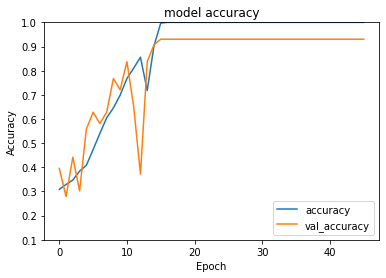

In [ ]:
plot_accuracy_graph(vgg_crop_vhflip_brightness)

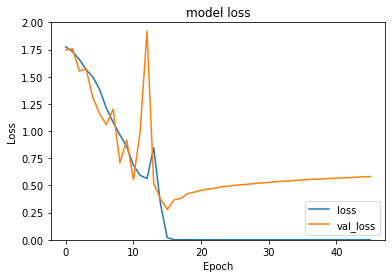

In [ ]:
plot_loss_graph(vgg_crop_vhflip_brightness, 0, 2)

In [ ]:
try:
  best_vgg_crop_vhflip_brightness = models.load_model("vgg_crop_vhflip_brightness.h5")
except OSError as error:
  print(error)
  best_vgg_crop_vhflip_brightness = loadmodel('best_vgg_crop_vhflip_brightness')
best_vgg_crop_vhflip_brightness.evaluate(val_data_gen)

2/2 [==============================] - 0s 69ms/step - loss: 0.2784 - accuracy: 0.9302


[0.27836716175079346, 0.930232584476471]

In [ ]:
best_vgg_crop_vhflip_brightness.evaluate(val_data_vhflip_brightness_gen)

11/11 [==============================] - 3s 249ms/step - loss: 0.3160 - accuracy: 0.9448


[0.31604185700416565, 0.944767415523529]

In [ ]:
preds = best_vgg_crop_vhflip_brightness.predict(val_data_vhflip_brightness_gen,verbose=1)

Ypred = np.argmax(preds, axis=1)
Ytest = val_data_vhflip_brightness_gen.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=CLASS_NAMES, digits=3))

11/11 [==============================] - 2s 153ms/step
                   precision    recall  f1-score   support

   Density4Benign      1.000     1.000     1.000        16
   Density1Benign      1.000     0.850     0.919        40
Density3Malignant      1.000     1.000     1.000        24
   Density3Benign      1.000     0.800     0.889        40
Density4Malignant      1.000     1.000     1.000         8
   Density2Benign      1.000     1.000     1.000        16
Density1Malignant      0.867     0.948     0.905        96
Density2Malignant      0.954     1.000     0.977       104

         accuracy                          0.945       344
        macro avg      0.978     0.950     0.961       344
     weighted avg      0.949     0.945     0.944       344



[[ 16   0   0   0   0   0   0   0]
 [  0  34   0   0   0   0   6   0]
 [  0   0  24   0   0   0   0   0]
 [  0   0   0  32   0   0   8   0]
 [  0   0   0   0   8   0   0   0]
 [  0   0   0   0   0  16   0   0]
 [  0   0   0   0   0   0  91   5]
 [  0   0   0   0   0   0   0 104]]


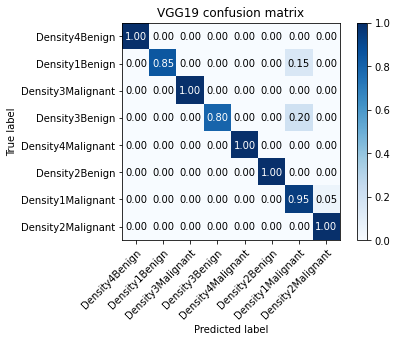

In [ ]:
cm = confusion_matrix(Ytest, Ypred, labels=None)
print(cm)
plot_confusion_matrix(Ytest, Ypred, classes=np.asarray(CLASS_NAMES), normalize=True, title='VGG19 confusion matrix')

In [ ]:
savemodel(best_vgg_crop_vhflip_brightness, 'best_vgg_crop_vhflip_brightness')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg_crop_vhflip_brightness.h5



# Custom CNN

In [ ]:
CNN = CustomCNN((IMG_WIDTH, IMG_HEIGHT, 3), 3, len(CLASS_NAMES), 1)
CNN2 = CustomCNN((IMG_WIDTH, IMG_HEIGHT, 3), 3, len(CLASS_NAMES), 2) #Same CNN with 2 layers of part A

## Train on plain Dataset

In [ ]:
custom_cnn = CNN.create_model()
custom_cnn.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn.h5", save_best_only=True),
]
custom_cnn.fit(train_data_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn)

Epoch 1/100
6/6 [==============================] - 30s 5s/step - loss: 2.0373 - accuracy: 0.2182 - val_loss: 2.0688 - val_accuracy: 0.3721
Epoch 2/100
6/6 [==============================] - 1s 100ms/step - loss: 1.9090 - accuracy: 0.3959 - val_loss: 2.0675 - val_accuracy: 0.3721
Epoch 3/100
6/6 [==============================] - 1s 98ms/step - loss: 1.8148 - accuracy: 0.5085 - val_loss: 2.0670 - val_accuracy: 0.3953
Epoch 4/100
6/6 [==============================] - 1s 95ms/step - loss: 1.8142 - accuracy: 0.4923 - val_loss: 2.0668 - val_accuracy: 0.3721
Epoch 5/100
6/6 [==============================] - 1s 99ms/step - loss: 1.7836 - accuracy: 0.5210 - val_loss: 2.0702 - val_accuracy: 0.3953
Epoch 6/100
6/6 [==============================] - 1s 95ms/step - loss: 1.7928 - accuracy: 0.5257 - val_loss: 2.0691 - val_accuracy: 0.4186
Epoch 7/100
6/6 [==============================] - 1s 98ms/step - loss: 1.8117 - accuracy: 0.5112 - val_loss: 2.0453 - val_accuracy: 0.4186
Epoch 8/100
6/6 [===

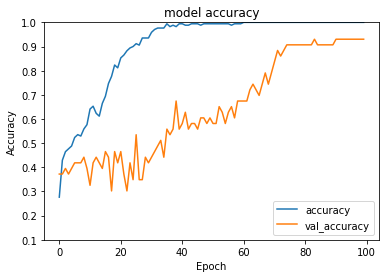

In [ ]:
plot_accuracy_graph(custom_cnn)

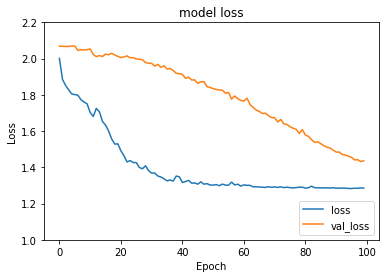

In [ ]:
plot_loss_graph(custom_cnn, 1, 2.2)

In [ ]:
try:
  best_custom_cnn = models.load_model("custom_cnn.h5")
except OSError as error:
  print(error)
  best_custom_cnn = loadmodel('best_custom_cnn')

best_custom_cnn.evaluate(val_data_gen)

2/2 [==============================] - 0s 23ms/step - loss: 1.4318 - accuracy: 0.9302


[1.4317924976348877, 0.930232584476471]

In [ ]:
savemodel(best_custom_cnn, 'best_custom_cnn')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_custom_cnn.h5



## Train on plain Dataset with 2 layers cnn

In [ ]:
custom_cnn2 = CNN2.create_model()
custom_cnn2.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

0


In [ ]:
callbacks_custom_cnn2 = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn2.h5", save_best_only=True),
]
custom_cnn2.fit(train_data_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn2)

Epoch 1/100
6/6 [==============================] - 1s 146ms/step - loss: 2.0483 - accuracy: 0.2259 - val_loss: 2.0782 - val_accuracy: 0.3256
Epoch 2/100
6/6 [==============================] - 1s 107ms/step - loss: 1.9144 - accuracy: 0.3912 - val_loss: 2.0781 - val_accuracy: 0.1395
Epoch 3/100
6/6 [==============================] - 1s 93ms/step - loss: 1.8918 - accuracy: 0.4133 - val_loss: 2.0789 - val_accuracy: 0.1395
Epoch 4/100
6/6 [==============================] - 1s 93ms/step - loss: 1.8638 - accuracy: 0.4404 - val_loss: 2.0807 - val_accuracy: 0.0930
Epoch 5/100
6/6 [==============================] - 1s 94ms/step - loss: 1.8671 - accuracy: 0.4386 - val_loss: 2.0831 - val_accuracy: 0.0465
Epoch 6/100
6/6 [==============================] - 1s 107ms/step - loss: 1.8302 - accuracy: 0.4910 - val_loss: 2.0841 - val_accuracy: 0.0465
Epoch 7/100
6/6 [==============================] - 1s 93ms/step - loss: 1.8341 - accuracy: 0.4955 - val_loss: 2.0866 - val_accuracy: 0.0465
Epoch 8/100
6/6 [

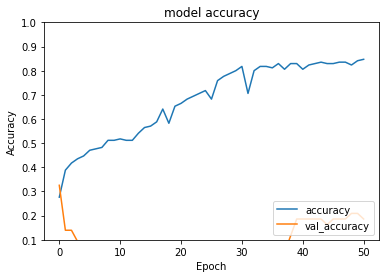

In [ ]:
plot_accuracy_graph(custom_cnn2)

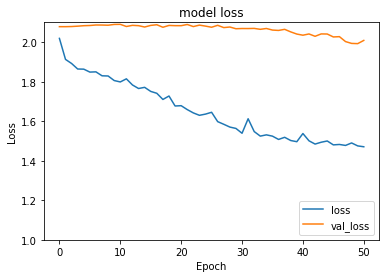

In [ ]:
plot_loss_graph(custom_cnn2, 1, 2.1)

In [ ]:
try:
  best_custom_cnn2 = models.load_model("custom_cnn2.h5")
except OSError as error:
  print(error)
  best_custom_cnn2 = loadmodel('best_custom_cnn2')

best_custom_cnn2.evaluate(val_data_gen)

2/2 [==============================] - 0s 33ms/step - loss: 1.9924 - accuracy: 0.2093


[1.9923661947250366, 0.20930232107639313]

In [ ]:
savemodel(best_custom_cnn2, 'best_custom_cnn2')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_custom_cnn2.h5



## Train on cropped Dataset

In [ ]:
custom_cnn_crop = CNN.create_model()
custom_cnn_crop.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_crop = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_crop.h5", save_best_only=True),
]
custom_cnn_crop.fit(train_data_crop_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_crop)

Epoch 1/100
11/11 [==============================] - 60s 5s/step - loss: 2.0021 - accuracy: 0.2887 - val_loss: 1.9280 - val_accuracy: 0.3721
Epoch 2/100
11/11 [==============================] - 1s 96ms/step - loss: 1.9122 - accuracy: 0.3822 - val_loss: 1.9287 - val_accuracy: 0.3721
Epoch 3/100
11/11 [==============================] - 1s 94ms/step - loss: 1.8902 - accuracy: 0.4099 - val_loss: 1.9274 - val_accuracy: 0.3721
Epoch 4/100
11/11 [==============================] - 1s 93ms/step - loss: 1.8752 - accuracy: 0.4312 - val_loss: 1.9314 - val_accuracy: 0.3721
Epoch 5/100
11/11 [==============================] - 1s 100ms/step - loss: 1.8301 - accuracy: 0.4927 - val_loss: 1.9334 - val_accuracy: 0.3953
Epoch 6/100
11/11 [==============================] - 1s 99ms/step - loss: 1.8149 - accuracy: 0.4928 - val_loss: 1.9359 - val_accuracy: 0.3721
Epoch 7/100
11/11 [==============================] - 1s 98ms/step - loss: 1.8636 - accuracy: 0.4486 - val_loss: 1.9364 - val_accuracy: 0.3953
Epoch 

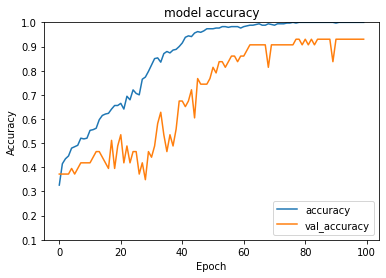

In [ ]:
plot_accuracy_graph(custom_cnn_crop)

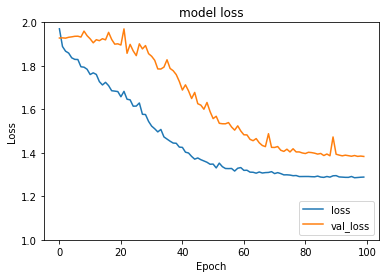

In [ ]:
plot_loss_graph(custom_cnn_crop, 1, 2)

In [ ]:
try:
  best_custom_cnn_crop = models.load_model("custom_cnn_crop.h5")
except OSError as error:
  print(error)
  best_custom_cnn_crop = loadmodel('best_custom_cnn_crop')

best_custom_cnn_crop.evaluate(val_data_gen)

2/2 [==============================] - 0s 28ms/step - loss: 1.3833 - accuracy: 0.9302


[1.3832992315292358, 0.930232584476471]

In [ ]:
savemodel(best_custom_cnn_crop, 'best_custom_cnn_crop')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_custom_cnn_crop.h5



## Train on cropped Dataset with 2 layers

In [ ]:
custom_cnn_crop2 = CNN2.create_model()
custom_cnn_crop2.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

0


In [ ]:
callbacks_custom_cnn_crop2 = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_crop2.h5", save_best_only=True),
]
custom_cnn_crop2.fit(train_data_crop_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_crop2)

Epoch 1/100
11/11 [==============================] - 2s 118ms/step - loss: 2.0771 - accuracy: 0.1414 - val_loss: 2.0760 - val_accuracy: 0.3023
Epoch 2/100
11/11 [==============================] - 1s 97ms/step - loss: 2.0412 - accuracy: 0.1801 - val_loss: 2.0720 - val_accuracy: 0.3023
Epoch 3/100
11/11 [==============================] - 1s 96ms/step - loss: 1.9959 - accuracy: 0.2803 - val_loss: 2.0661 - val_accuracy: 0.3023
Epoch 4/100
11/11 [==============================] - 1s 98ms/step - loss: 1.9451 - accuracy: 0.3429 - val_loss: 2.0518 - val_accuracy: 0.3023
Epoch 5/100
11/11 [==============================] - 1s 95ms/step - loss: 1.9394 - accuracy: 0.3622 - val_loss: 2.0424 - val_accuracy: 0.3023
Epoch 6/100
11/11 [==============================] - 1s 96ms/step - loss: 1.9037 - accuracy: 0.4391 - val_loss: 2.0329 - val_accuracy: 0.3023
Epoch 7/100
11/11 [==============================] - 1s 97ms/step - loss: 1.9175 - accuracy: 0.3845 - val_loss: 2.0194 - val_accuracy: 0.3023
Epoch

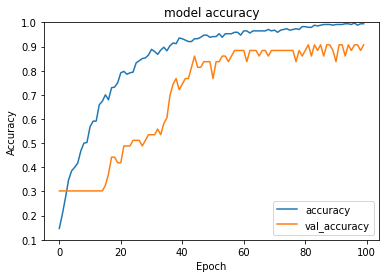

In [ ]:
plot_accuracy_graph(custom_cnn_crop2)

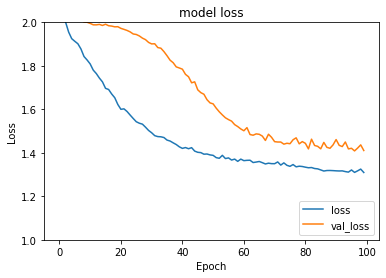

In [ ]:
plot_loss_graph(custom_cnn_crop2, 1, 2)

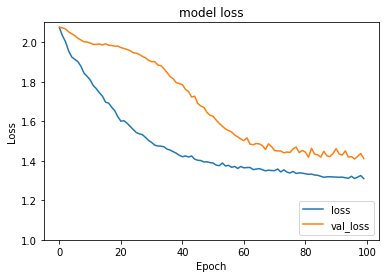

In [ ]:
try:
  plot_loss_graph(custom_cnn_crop2, 1, 2.1)
except OSError as error:
  print(error)
  custom_cnn_crop2 = loadmodel('best_custom_cnn_crop2')
  plot_loss_graph(custom_cnn_crop2, 1, 2.1)

In [ ]:
custom_cnn_crop2 = models.load_model("custom_cnn_crop2.h5")
custom_cnn_crop2.evaluate(val_data_gen)

2/2 [==============================] - 0s 26ms/step - loss: 1.4088 - accuracy: 0.9070


[1.4087904691696167, 0.9069767594337463]

## Train on horizontal flip Dataset

In [ ]:
custom_cnn_hflip = CNN.create_model()
custom_cnn_hflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_hflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_hflip.h5", save_best_only=True),
]
custom_cnn_hflip.fit(train_data_hflip_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_hflip)

Epoch 1/100
11/11 [==============================] - 50s 4s/step - loss: 2.0969 - accuracy: 0.1041 - val_loss: 2.0786 - val_accuracy: 0.3488
Epoch 2/100
11/11 [==============================] - 1s 99ms/step - loss: 2.0201 - accuracy: 0.2187 - val_loss: 2.0754 - val_accuracy: 0.4884
Epoch 3/100
11/11 [==============================] - 1s 96ms/step - loss: 1.8796 - accuracy: 0.4721 - val_loss: 2.0739 - val_accuracy: 0.5116
Epoch 4/100
11/11 [==============================] - 1s 99ms/step - loss: 1.7741 - accuracy: 0.6000 - val_loss: 2.0712 - val_accuracy: 0.4884
Epoch 5/100
11/11 [==============================] - 1s 103ms/step - loss: 1.6878 - accuracy: 0.7038 - val_loss: 2.0685 - val_accuracy: 0.3953
Epoch 6/100
11/11 [==============================] - 1s 97ms/step - loss: 1.6034 - accuracy: 0.7830 - val_loss: 2.0649 - val_accuracy: 0.4419
Epoch 7/100
11/11 [==============================] - 1s 98ms/step - loss: 1.5567 - accuracy: 0.8376 - val_loss: 2.0609 - val_accuracy: 0.3488
Epoch 

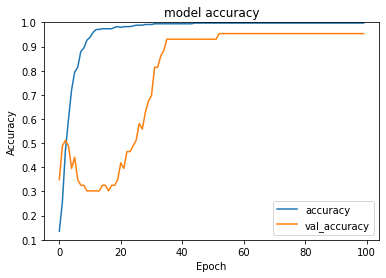

In [ ]:
plot_accuracy_graph(custom_cnn_hflip)

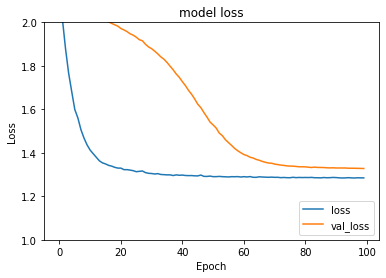

In [ ]:
plot_loss_graph(custom_cnn_hflip, 1, 2)

In [ ]:
try:
  best_custom_cnn_hflip = models.load_model("custom_cnn_hflip.h5")
except OSError as error:
  print(error)
  best_custom_cnn_hflip = loadmodel('best_custom_cnn_hflip')
  
best_custom_cnn_hflip.evaluate(val_data_gen)

2/2 [==============================] - 0s 27ms/step - loss: 1.3280 - accuracy: 0.9535


[1.3279975652694702, 0.9534883499145508]

In [ ]:
savemodel(best_custom_cnn_hflip, 'best_custom_cnn_hflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_custom_cnn_hflip.h5



## Train on vertical flip Dataset

In [ ]:
custom_cnn_vflip = CNN.create_model()
custom_cnn_vflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_vflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_vflip.h5", save_best_only=True),
]
custom_cnn_vflip.fit(train_data_vflip_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_vflip)

Epoch 1/100
11/11 [==============================] - 53s 5s/step - loss: 2.0036 - accuracy: 0.2867 - val_loss: 1.9743 - val_accuracy: 0.3721
Epoch 2/100
11/11 [==============================] - 1s 97ms/step - loss: 1.9040 - accuracy: 0.4146 - val_loss: 1.9756 - val_accuracy: 0.3721
Epoch 3/100
11/11 [==============================] - 1s 96ms/step - loss: 1.8743 - accuracy: 0.4412 - val_loss: 1.9834 - val_accuracy: 0.3721
Epoch 4/100
11/11 [==============================] - 1s 96ms/step - loss: 1.8387 - accuracy: 0.4903 - val_loss: 1.9856 - val_accuracy: 0.4186
Epoch 5/100
11/11 [==============================] - 1s 99ms/step - loss: 1.8267 - accuracy: 0.5051 - val_loss: 2.0016 - val_accuracy: 0.4186
Epoch 6/100
11/11 [==============================] - 1s 95ms/step - loss: 1.8285 - accuracy: 0.5177 - val_loss: 1.9786 - val_accuracy: 0.3953
Epoch 7/100
11/11 [==============================] - 1s 98ms/step - loss: 1.7825 - accuracy: 0.5329 - val_loss: 2.0030 - val_accuracy: 0.4186
Epoch 8

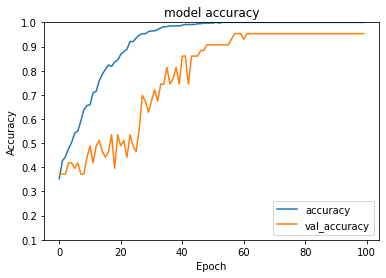

In [ ]:
plot_accuracy_graph(custom_cnn_vflip)

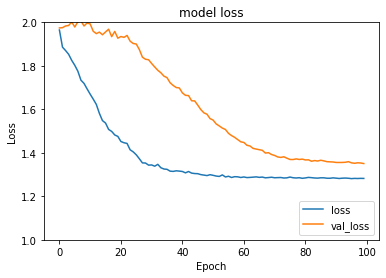

In [ ]:
plot_loss_graph(custom_cnn_vflip, 1, 2)

In [ ]:
try:
  best_custom_cnn_vflip = models.load_model("custom_cnn_vflip.h5")
except OSError as error:
  print(error)
  best_custom_cnn_vflip = loadmodel('best_custom_cnn_vflip')
  
best_custom_cnn_vflip.evaluate(val_data_gen)

2/2 [==============================] - 0s 24ms/step - loss: 1.3507 - accuracy: 0.9535


[1.3506803512573242, 0.9534883499145508]

In [ ]:
savemodel(best_custom_cnn_vflip, 'best_custom_cnn_vflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_custom_cnn_vflip.h5



## Train on brightness Dataset

In [ ]:
custom_cnn_brightness = CNN.create_model()
custom_cnn_brightness.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_brightness = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_brightness.h5", save_best_only=True),
]
custom_cnn_brightness.fit(train_data_brightness_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_brightness)

Epoch 1/100
11/11 [==============================] - 48s 4s/step - loss: 1.9744 - accuracy: 0.3112 - val_loss: 2.0024 - val_accuracy: 0.3721
Epoch 2/100
11/11 [==============================] - 1s 100ms/step - loss: 1.8766 - accuracy: 0.4108 - val_loss: 1.9813 - val_accuracy: 0.3721
Epoch 3/100
11/11 [==============================] - 1s 100ms/step - loss: 1.8697 - accuracy: 0.4255 - val_loss: 1.9739 - val_accuracy: 0.3721
Epoch 4/100
11/11 [==============================] - 1s 100ms/step - loss: 1.8461 - accuracy: 0.4425 - val_loss: 1.9702 - val_accuracy: 0.3721
Epoch 5/100
11/11 [==============================] - 1s 100ms/step - loss: 1.8604 - accuracy: 0.4102 - val_loss: 1.9718 - val_accuracy: 0.3721
Epoch 6/100
11/11 [==============================] - 1s 98ms/step - loss: 1.8122 - accuracy: 0.4816 - val_loss: 1.9745 - val_accuracy: 0.3953
Epoch 7/100
11/11 [==============================] - 1s 97ms/step - loss: 1.8174 - accuracy: 0.4988 - val_loss: 1.9692 - val_accuracy: 0.4186
Epo

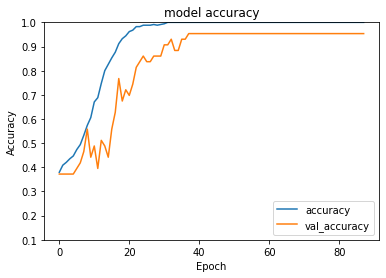

In [ ]:
plot_accuracy_graph(custom_cnn_brightness)

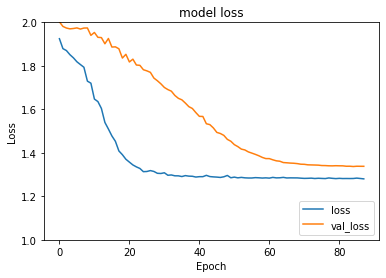

In [ ]:
plot_loss_graph(custom_cnn_brightness, 1, 2)

In [ ]:
try:
  best_custom_cnn_brightness = models.load_model("custom_cnn_brightness.h5")
except OSError as error:
  print(error)
  best_custom_cnn_brightness = loadmodel('best_custom_cnn_brightness')

best_custom_cnn_brightness.evaluate(val_data_gen)

2/2 [==============================] - 0s 26ms/step - loss: 1.3370 - accuracy: 0.9535


[1.3370479345321655, 0.9534883499145508]

In [ ]:
savemodel(best_custom_cnn_brightness, 'best_custom_cnn_brightness')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_custom_cnn_brightness.h5



## Train on cropped and vertical flip Dataset

In [ ]:
custom_cnn_crop_vflip = CNN.create_model()
custom_cnn_crop_vflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_crop_vflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_crop_vflip.h5", save_best_only=True),
]
custom_cnn_crop_vflip.fit(train_data_crop_vflip_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_crop_vflip)

Epoch 1/100
22/22 [==============================] - 104s 5s/step - loss: 2.0016 - accuracy: 0.2823 - val_loss: 1.9780 - val_accuracy: 0.3721
Epoch 2/100
22/22 [==============================] - 2s 96ms/step - loss: 1.8823 - accuracy: 0.4301 - val_loss: 1.9702 - val_accuracy: 0.3721
Epoch 3/100
22/22 [==============================] - 2s 95ms/step - loss: 1.8893 - accuracy: 0.4159 - val_loss: 1.9818 - val_accuracy: 0.3721
Epoch 4/100
22/22 [==============================] - 2s 96ms/step - loss: 1.8628 - accuracy: 0.4461 - val_loss: 1.9764 - val_accuracy: 0.3953
Epoch 5/100
22/22 [==============================] - 2s 95ms/step - loss: 1.8030 - accuracy: 0.4993 - val_loss: 1.9702 - val_accuracy: 0.3953
Epoch 6/100
22/22 [==============================] - 2s 96ms/step - loss: 1.7876 - accuracy: 0.5172 - val_loss: 1.9717 - val_accuracy: 0.3953
Epoch 7/100
22/22 [==============================] - 2s 96ms/step - loss: 1.7833 - accuracy: 0.5308 - val_loss: 1.9419 - val_accuracy: 0.3953
Epoch 

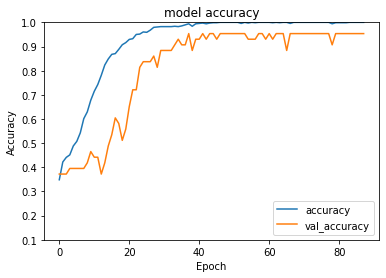

In [ ]:
plot_accuracy_graph(custom_cnn_crop_vflip)

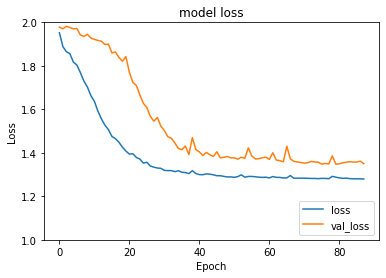

In [ ]:
plot_loss_graph(custom_cnn_crop_vflip, 1, 2)

In [ ]:
try:
  best_custom_cnn_crop_vflip = models.load_model("custom_cnn_crop_vflip.h5")
except OSError as error:
  print(error)
  best_custom_cnn_crop_vflip = loadmodel('best_custom_cnn_crop_vflip')
  
best_custom_cnn_crop_vflip.evaluate(val_data_gen)

2/2 [==============================] - 0s 26ms/step - loss: 1.3478 - accuracy: 0.9535


[1.3478037118911743, 0.9534883499145508]

In [ ]:
savemodel(best_custom_cnn_crop_vflip, 'best_custom_cnn_crop_vflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_custom_cnn_crop_vflip.h5



## Train on cropped, vertical and horizontal flip Dataset

In [ ]:
custom_cnn_crop_vhflip = CNN.create_model()
custom_cnn_crop_vhflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_crop_vhflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_crop_vhflip.h5", save_best_only=True),
]
custom_cnn_crop_vhflip.fit(train_data_crop_vhflip_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_crop_vhflip)

Epoch 1/100
43/43 [==============================] - 210s 5s/step - loss: 2.0502 - accuracy: 0.2018 - val_loss: 2.0751 - val_accuracy: 0.2093
Epoch 2/100
43/43 [==============================] - 4s 98ms/step - loss: 1.9969 - accuracy: 0.2912 - val_loss: 2.0766 - val_accuracy: 0.2093
Epoch 3/100
43/43 [==============================] - 4s 99ms/step - loss: 1.9640 - accuracy: 0.3322 - val_loss: 2.0734 - val_accuracy: 0.2093
Epoch 4/100
43/43 [==============================] - 4s 98ms/step - loss: 1.9399 - accuracy: 0.3470 - val_loss: 2.0695 - val_accuracy: 0.2093
Epoch 5/100
43/43 [==============================] - 4s 99ms/step - loss: 1.9159 - accuracy: 0.4033 - val_loss: 2.0704 - val_accuracy: 0.2093
Epoch 6/100
43/43 [==============================] - 4s 100ms/step - loss: 1.9157 - accuracy: 0.3678 - val_loss: 2.0673 - val_accuracy: 0.2093
Epoch 7/100
43/43 [==============================] - 4s 99ms/step - loss: 1.8825 - accuracy: 0.4200 - val_loss: 2.0687 - val_accuracy: 0.2093
Epoch

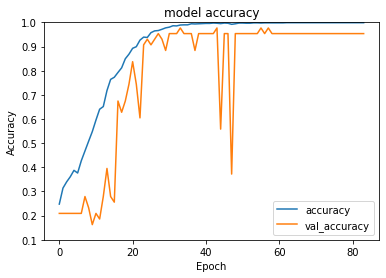

In [ ]:
plot_accuracy_graph(custom_cnn_crop_vhflip)

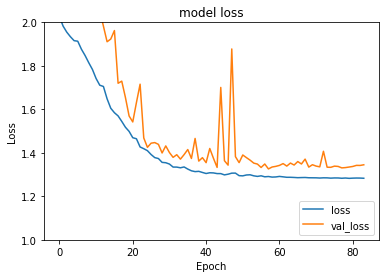

In [ ]:
plot_loss_graph(custom_cnn_crop_vhflip, 1, 2)

In [ ]:
try:
  best_custom_cnn_crop_vhflip = models.load_model("custom_cnn_crop_vhflip.h5")
except OSError as error:
  print(error)
  best_custom_cnn_crop_vhflip = loadmodel('best_custom_cnn_crop_vhflip')
  
best_custom_cnn_crop_vhflip.evaluate(val_data_gen)

2/2 [==============================] - 0s 24ms/step - loss: 1.3259 - accuracy: 0.9767


[1.325896978378296, 0.9767441749572754]

In [ ]:
savemodel(best_custom_cnn_crop_vhflip, 'best_custom_cnn_crop_vhflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_custom_cnn_crop_vhflip.h5



## Train on cropped, vertical, horizontal flip and brightness Dataset

In [ ]:
custom_cnn_crop_vhflip_brightness = CNN.create_model()
custom_cnn_crop_vhflip_brightness.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_crop_vhflip_brightness = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_crop_vhflip_brightness.h5", save_best_only=True),
]
custom_cnn_crop_vhflip_brightness.fit(train_data_crop_vflip_hflip_brightness_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_crop_vhflip_brightness)

Epoch 1/100
85/85 [==============================] - 10s 107ms/step - loss: 2.0265 - accuracy: 0.2456 - val_loss: 2.0582 - val_accuracy: 0.3023
Epoch 2/100
85/85 [==============================] - 9s 103ms/step - loss: 2.0053 - accuracy: 0.2869 - val_loss: 2.0387 - val_accuracy: 0.2791
Epoch 3/100
85/85 [==============================] - 9s 101ms/step - loss: 1.9850 - accuracy: 0.2976 - val_loss: 2.0187 - val_accuracy: 0.2791
Epoch 4/100
85/85 [==============================] - 9s 101ms/step - loss: 1.9714 - accuracy: 0.3139 - val_loss: 2.0168 - val_accuracy: 0.2326
Epoch 5/100
85/85 [==============================] - 9s 102ms/step - loss: 1.9934 - accuracy: 0.2917 - val_loss: 1.9964 - val_accuracy: 0.2791
Epoch 6/100
85/85 [==============================] - 9s 102ms/step - loss: 1.9663 - accuracy: 0.3255 - val_loss: 1.9800 - val_accuracy: 0.2791
Epoch 7/100
85/85 [==============================] - 9s 100ms/step - loss: 1.9142 - accuracy: 0.3868 - val_loss: 1.9036 - val_accuracy: 0.418

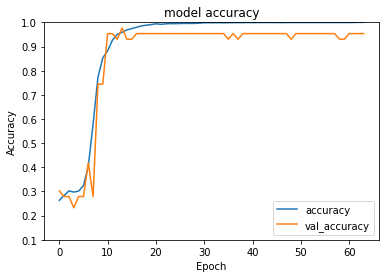

In [ ]:
plot_accuracy_graph(custom_cnn_crop_vhflip_brightness)

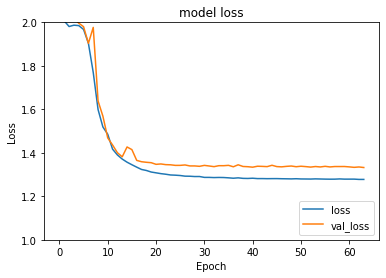

In [ ]:
plot_loss_graph(custom_cnn_crop_vhflip_brightness, 1, 2)

In [ ]:
try:
  best_custom_cnn_crop_vhflip_brightness = models.load_model("custom_cnn_crop_vhflip_brightness.h5")
except OSError as error:
  print(error)
  best_custom_cnn_crop_vhflip_brightness = loadmodel('best_custom_cnn_crop_vhflip_brightness')

best_custom_cnn_crop_vhflip_brightness.evaluate(val_data_gen)

2/2 [==============================] - 0s 22ms/step - loss: 1.3324 - accuracy: 0.9535


[1.3324276208877563, 0.9534883499145508]

In [ ]:
preds = best_custom_cnn_crop_vhflip_brightness.predict(val_data_vhflip_brightness_gen,verbose=1)

Ypred = np.argmax(preds, axis=1)
Ytest = val_data_vhflip_brightness_gen.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=CLASS_NAMES, digits=3))

11/11 [==============================] - 1s 87ms/step
                   precision    recall  f1-score   support

   Density4Benign      0.778     0.875     0.824        16
   Density1Benign      0.950     0.950     0.950        40
Density3Malignant      0.923     1.000     0.960        24
   Density3Benign      1.000     0.800     0.889        40
Density4Malignant      1.000     1.000     1.000         8
   Density2Benign      1.000     1.000     1.000        16
Density1Malignant      0.978     0.938     0.957        96
Density2Malignant      0.929     1.000     0.963       104

         accuracy                          0.948       344
        macro avg      0.945     0.945     0.943       344
     weighted avg      0.951     0.948     0.947       344



[[ 14   0   0   0   0   0   0   2]
 [  0  38   0   0   0   0   2   0]
 [  0   0  24   0   0   0   0   0]
 [  4   2   0  32   0   0   0   2]
 [  0   0   0   0   8   0   0   0]
 [  0   0   0   0   0  16   0   0]
 [  0   0   2   0   0   0  90   4]
 [  0   0   0   0   0   0   0 104]]


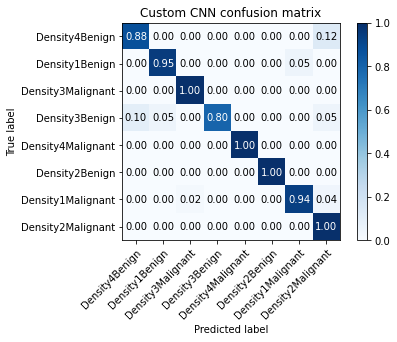

In [ ]:
cm = confusion_matrix(Ytest, Ypred, labels=None)
print(cm)
plot_confusion_matrix(Ytest, Ypred, classes=np.asarray(CLASS_NAMES), normalize=True, title='Custom CNN confusion matrix')

In [ ]:
savemodel(best_custom_cnn_crop_vhflip_brightness, 'best_custom_cnn_crop_vhflip_brightness')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_custom_cnn_crop_vhflip_brightness.h5

